# OVERVIEW
In machine learning we need to do lot feature engineering and many experiments to find the best model. If we do not have a solid validation stratergy it would impossible to find the best model as we can not make comparison between model performance fairly. 
But since we have limited amout data it is not possible for us to have enough data for testing our models. So we use cross validation which divides the dataset into train fold and validation fold and use the score from the validation to find the best model. The most important parameter for cross validation is number folds k.
In this notebook we would figure out how to select the best value for k in cross validation and also how to find the best model from a group models using a diiferent no of folds.

For selecting the best value for k we will this article as reference - https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

As for how to select the best model we will folow this article - https://cran.r-project.org/web/packages/cvms/vignettes/picking_the_number_of_folds_for_cross-validation.html

# FIND THE BEST VALUE FOR K
Before finding the best value for k I want to elaborate why it is necessary using the competition dataset. The next block of code import necessary packages

In [1]:
# loading packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, StratifiedKFold, KFold, RepeatedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from copy import deepcopy


from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor


from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from category_encoders import TargetEncoder, MEstimateEncoder

from sklearn.metrics import RocCurveDisplay, auc, classification_report, roc_auc_score, mean_absolute_error
from scipy.stats import pearsonr


from path import Path
import warnings 
warnings.filterwarnings('ignore') # supress warnings

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The next line of code just a fancy way of getting folds which can also be implemented with just basic StratifiedKFold

In [2]:
class Splitter:
    """A splitter class which splits the X, y using the split_data function with a random state provided. It yeilds \
    X_train, X_val, y_train, y_val, train_idx, val_idx in the end.\
    code from  https://www.kaggle.com/code/tetsutani/ps3e9-eda-and-gbdt-catboost-median-duplicatedata wit little bit of modification """

    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size # set test size
        self.kfold = kfold  # wheter to just split the data in two or use kfold
        self.n_splits= n_splits # set 
        
    def split_data(self, X, y, split_sr, random_state):
        if self.kfold:
            skf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
            for train_idx, val_idx in skf.split(X, split_sr):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                yield X_train, X_val, y_train, y_val, train_idx, val_idx
        else:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
            yield X_train, X_val, y_train, y_val


In [3]:
# loading datasets
path = Path("/kaggle/input/playground-series-s3e14")
train = pd.read_csv(path / "train.csv")
target = 'yield'

# the line of code below bins the dataset into 5 parts so that we have equal amount of values in validation set as the training
# set in all 5 parts. It just ensures more robustness in our validation stratergy.
train_temp = train.copy()
train_temp['bins'] = pd.qcut(train_temp[target], q=5)
bin_map = {}
for i, _bin in enumerate(train_temp['bins'].unique()):
    bin_map[_bin] = i
train_temp['bins'] = train_temp['bins'].map(bin_map)

# X and y
X = train_temp.drop(['id', 'bins', target], axis=1)
y = train_temp[target]
split_sr = train_temp['bins']

The next line of code contains a funcation which evaluates model with 4 repeats with a given value of k-fold

In [4]:
def evaluate_model_repeats(model_name, model_pipeline, y_pipeline, _X, _y, split_sr, features, n_splits=5, random_state_list=[0, 5, 10], verbose=True):
    len_y = len(_y)
    len_states = len(random_state_list)

    oof_preds = np.zeros(len_y * len_states).reshape(len_states, len_y)
    models_pipeline = []
    scores_train = []
    scores_val = []
    train_means = []
    val_means = []

    
    for index, random_state in enumerate(random_state_list):
        if verbose:
            print("#"*25)
            print("#"*15, f"traininng model {model_name} with seed {random_state}")
            print("#"*25)
            
        splitter = Splitter(n_splits=n_splits) 
        splits = 0
        
        for X_train, X_val, y_train, y_val, train_idx, val_idx in splitter.split_data(_X, _y, split_sr, random_state):
#         transforming y for distance based algorithm
            pros_y_train = y_pipeline.fit_transform(y_train.to_frame()).flatten()
#         fitting model
            model_pipeline.fit(X_train, pros_y_train)
#         making predictions for train and validation set
            train_preds = y_pipeline.inverse_transform(model_pipeline.predict(X_train).reshape(-1, 1)).flatten()
            val_preds = y_pipeline.inverse_transform(model_pipeline.predict(X_val).reshape(-1, 1)).flatten()
#         storing validation preds for future use
            oof_preds[index, val_idx] = val_preds
#         train and validation score in each split     
            score_train = mean_absolute_error(y_train, train_preds)
            score_val = mean_absolute_error(y_val, val_preds)
            
            models_pipeline.append(deepcopy(model_pipeline))
            scores_train.append(score_train)
            scores_val.append(score_val)
            train_means.append(y_train.mean())
            val_means.append(val_preds.mean())

            splits += 1
            if verbose:
                print(f"seed {random_state} and split {splits} mean absoulte error {score_val}")

          
    oof_preds_mean = oof_preds
    mean_train_score = np.mean(scores_train)
    mean_val_score = np.mean(scores_val)
    cv_gap = mean_train_score - mean_val_score
    val_std = np.std(scores_val)
    sem = np.abs(np.array(train_means) - np.array(val_means)).mean()
    print()
    print(f'{model_name} Average  mean abosulte error: {np.mean(scores_val)}')

# returns all the trained models for each splits and also the predictions in each repeat, mean train score and validation score
# also the difference between train and validation score, the standard devidations in validation and standard error around the mean
# in each repeats
    return models_pipeline, oof_preds_mean, mean_train_score, mean_val_score, cv_gap, val_std, sem

In [5]:
%%time
n_splits= 5
random_states = [0, 5, 10, 15]
feats = X.columns.to_list()

classifiers = {
    "lr": LinearRegression(),
    "gb": GradientBoostingRegressor(random_state=0),
    'hist': HistGradientBoostingRegressor(random_state=0),
    'lgbm': LGBMRegressor(random_state=0),
    "cat": CatBoostRegressor(silent=True, random_state=0)
}

models_log = pd.DataFrame(columns=['model_name', 'no_of_fold', 'train_error', "valid_error", "cv_gap", "std", "sem"],
                          index=range(len(classifiers)*5))
index = 0

process_y = make_pipeline(StandardScaler())

for n_splits in [3, 5, 6, 7, 10, 15, 20]:
    for model_name, model in classifiers.items():


        model_pipe = make_pipeline(StandardScaler(), model)  
        _models, _oof_preds, _train_score, _oof_val_score, _cv_gap, _std, _sem=evaluate_model_repeats(model_name, model_pipe, process_y, 
                                                                            X, y, split_sr, feats,
                                                                            n_splits=n_splits, random_state_list=random_states)

        models_log.loc[index] = [model_name, n_splits, _train_score, _oof_val_score, _cv_gap, _std, _sem]
        index += 1

#########################
############### traininng model lr with seed 0
#########################
seed 0 and split 1 mean absoulte error 381.76107207439225
seed 0 and split 2 mean absoulte error 377.0489489241835
seed 0 and split 3 mean absoulte error 362.4774054176326
#########################
############### traininng model lr with seed 5
#########################
seed 5 and split 1 mean absoulte error 357.16406410300516
seed 5 and split 2 mean absoulte error 380.8573956890778
seed 5 and split 3 mean absoulte error 378.13860735171045
#########################
############### traininng model lr with seed 10
#########################
seed 10 and split 1 mean absoulte error 378.2529551595568
seed 10 and split 2 mean absoulte error 367.4793243279164
seed 10 and split 3 mean absoulte error 370.2273255685436
#########################
############### traininng model lr with seed 15
#########################
seed 15 and split 1 mean absoulte error 370.40175955363964
seed 15 and split 2 mean

In [6]:
models_log

,model_name,no_of_fold,train_error,valid_error,cv_gap,std,sem
0,lr,3,370.779348,374.514875,-3.735527,10.685461,5.341294
1,gb,3,341.930516,355.417558,-13.487042,5.555423,4.279527
2,hist,3,328.859522,355.664372,-26.804851,6.20907,4.782156
3,lgbm,3,314.467052,357.066251,-42.599199,6.108956,4.48079
4,cat,3,299.260538,358.538542,-59.278004,6.062425,5.165251
5,lr,5,370.937574,372.349628,-1.412054,9.920074,7.096719
6,gb,5,343.147929,354.797578,-11.649649,7.344103,6.441347
7,hist,5,329.809642,354.217018,-24.407376,7.643142,6.684513
8,lgbm,5,317.935607,354.937548,-37.001941,7.701312,5.997689
9,cat,5,303.396446,356.245447,-52.849002,7.616112,6.204231


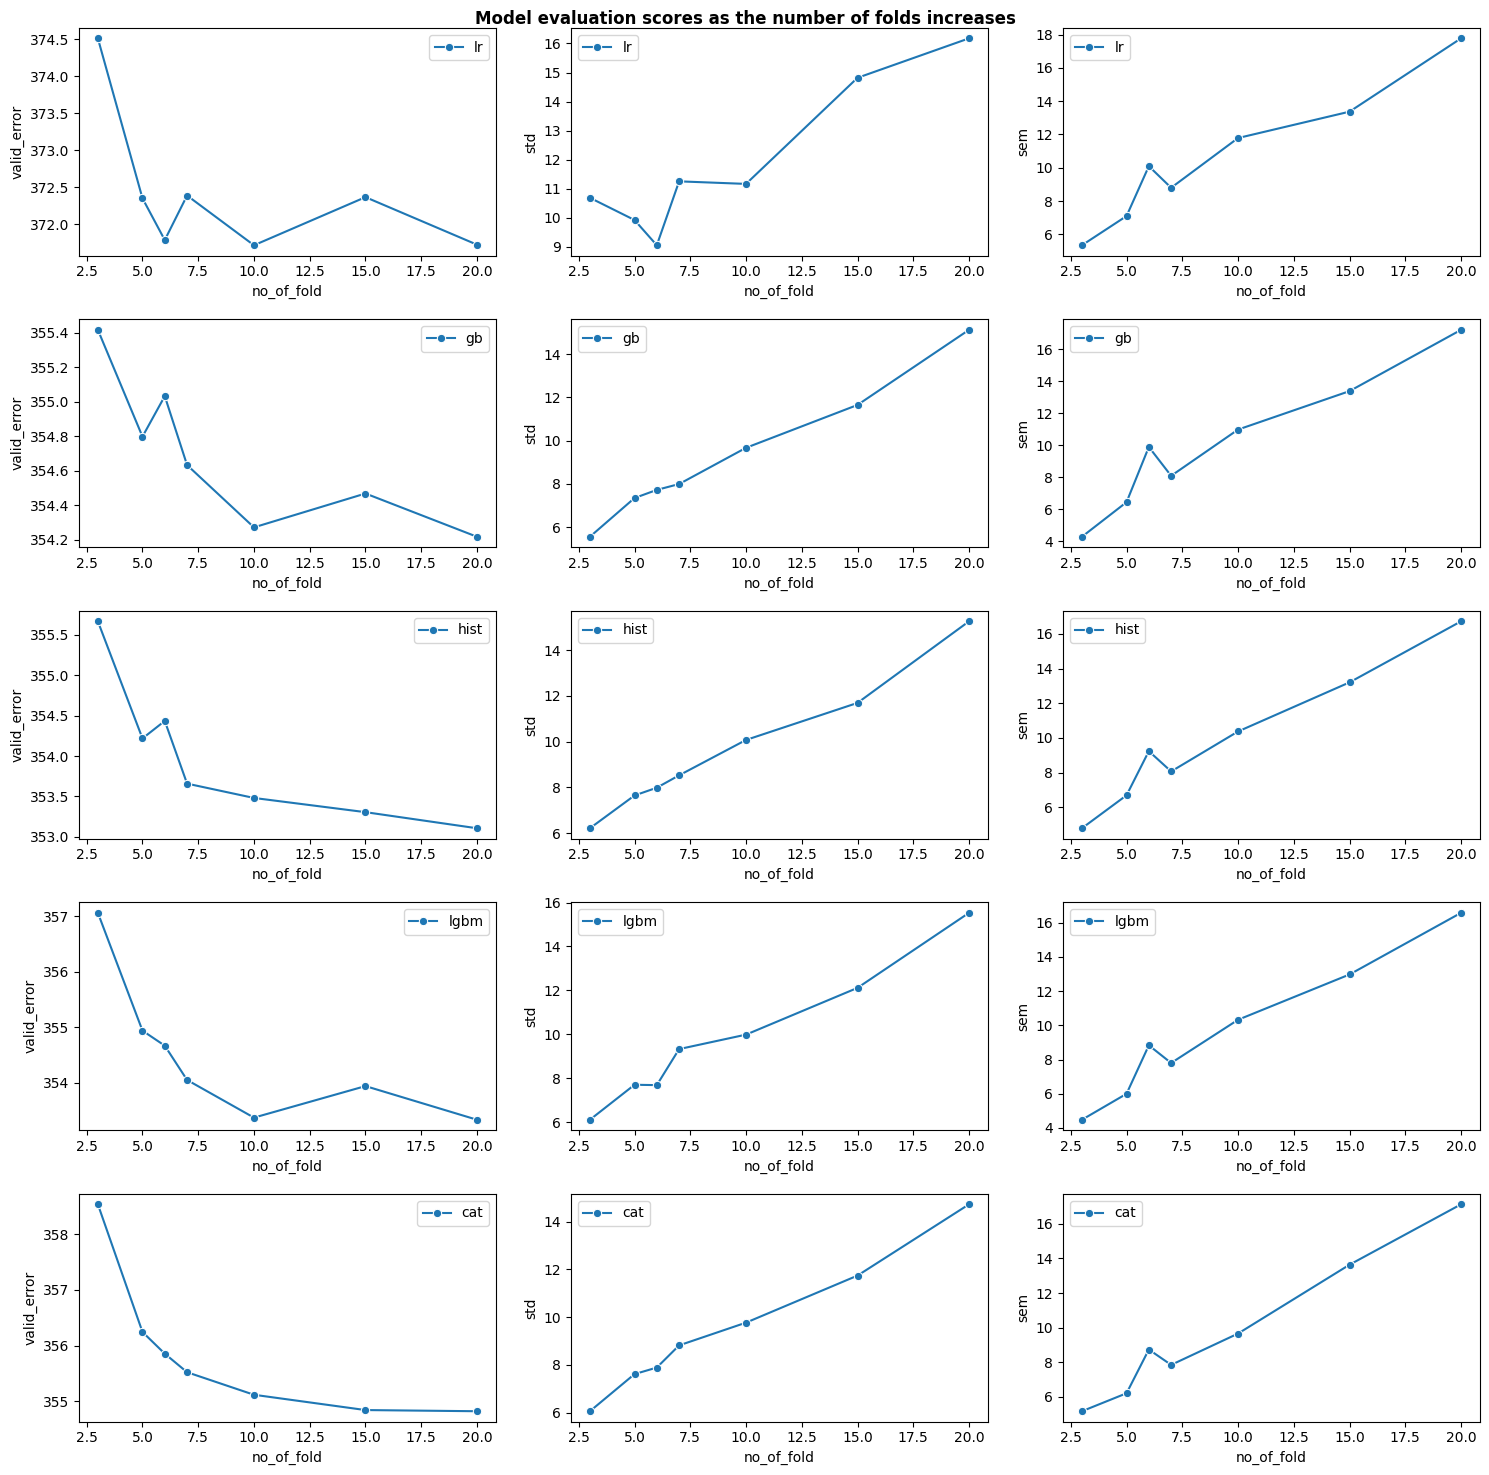

In [7]:
nrows = len(classifiers)
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 3*nrows))
for index, model_name in enumerate(classifiers.keys()):
    data = models_log[models_log['model_name'] == model_name]
    ax1 = sns.lineplot(data=data, x='no_of_fold', y='valid_error', ax=axes[index][0], marker='o')
    ax2 = sns.lineplot(data=data, x='no_of_fold', y='std', ax=axes[index][1], marker='o')
    ax3 = sns.lineplot(data=data, x='no_of_fold', y='sem', ax=axes[index][2], marker='o')
    
    ax1.legend(data['model_name'].unique())
    ax2.legend(data['model_name'].unique())
    ax3.legend(data['model_name'].unique())
   

fig.suptitle("Model evaluation scores as the number of folds increases", fontweight='bold')
plt.tight_layout()

From the plots you can see that generally as that number of folds increases the validation error decreases where as std and sem increases which makes senese because
* As the number of folds increases the train set gets bigger and validation set gets smaller. So we get less predictions error as during training the models the models see more available data even if some traning fold are a little different.
* But std and sem increases as we have less validation data which has higher chances of having different distribution mong themselves.Because we are only taking smaller validation data as folds increases
* As the number of folds gets lower the training set get samller and validation get bigger. So there is greater chance that the distribution in train is different than validation set. So we get more validation error with smaller folds
* But the std and sem gets smaller as we have more data in validation and they tend to have similar distribution because of bigger number of observation


****Normally the higher the number of fold the more the evaluation of the model is close to the true model evaluation(think of as the population mean). But as the number of fold increases the computation time also increases.****

To find out which is the best value of k which not only takes less time to evalute but also close to the true model evaluation we first need to find the true model evaluation which can be found using LeaveOneOut crossvalidation then we can compare it with another crossvalidation which smaller number of k and see if the model score is similar or not. But in our case since we have 15K observation we can not use LeaveOneOut cv. As an alternative we will use an cv with 150 folds.

In [8]:
model_lgbm = make_pipeline(StandardScaler(), LGBMRegressor(random_state=0))  
models_true, oof_preds_true, train_score_true, oof_val_score_true, cv_gap_true, std_true, sem_true =evaluate_model_repeats("lgbm_pipeline", 
                                                                    model_lgbm, process_y, 
                                                                    X, y, split_sr, feats,
                                                                    n_splits=150, random_state_list=[0, 5, 10])

#########################
############### traininng model lgbm_pipeline with seed 0
#########################
seed 0 and split 1 mean absoulte error 285.85280239399486
seed 0 and split 2 mean absoulte error 339.4333925346767
seed 0 and split 3 mean absoulte error 309.4862604678286
seed 0 and split 4 mean absoulte error 422.647243108186
seed 0 and split 5 mean absoulte error 392.78882898569
seed 0 and split 6 mean absoulte error 392.6866275351969
seed 0 and split 7 mean absoulte error 348.62042925993984
seed 0 and split 8 mean absoulte error 345.89326909460664
seed 0 and split 9 mean absoulte error 354.06120259207836
seed 0 and split 10 mean absoulte error 372.48166252596474
seed 0 and split 11 mean absoulte error 357.0507095552447
seed 0 and split 12 mean absoulte error 359.92279147996163
seed 0 and split 13 mean absoulte error 459.68422186242435
seed 0 and split 14 mean absoulte error 373.8849273440042
seed 0 and split 15 mean absoulte error 308.3992524199915
seed 0 and split 16 mean 

In [9]:
print(f"Approximate true LGBM model evaluation error {oof_val_score_true}, cv_gap_true: {cv_gap_true}, std_true: \
      {std_true}, sem_true:{sem_true}")

Approximate true LGBM model evaluation error 352.92313821185974, cv_gap_true: -31.263180995791515, std_true:       42.690836474429155, sem_true:47.62444476318889


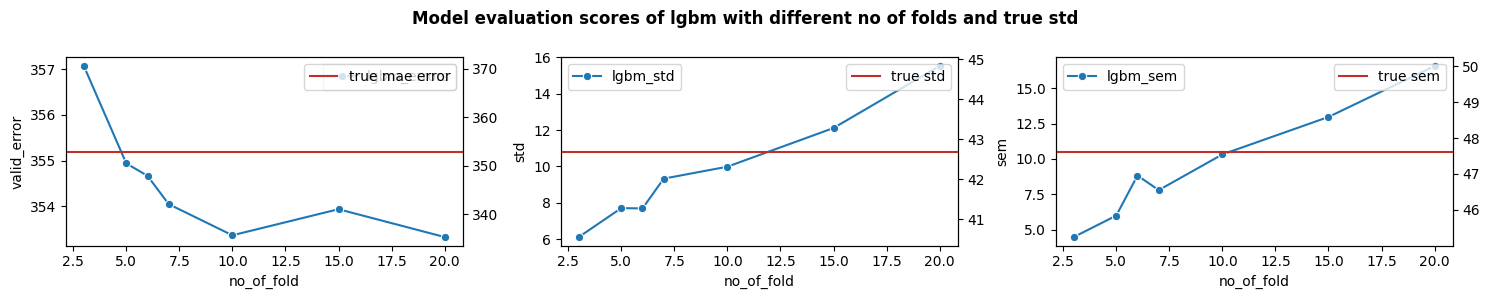

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

data = models_log[models_log['model_name'] == 'lgbm']
ax1 = sns.lineplot(data=data, x='no_of_fold', y='valid_error', ax=axes[0], marker='o')
ax2 = sns.lineplot(data=data, x='no_of_fold', y='std', ax=axes[1], marker='o')
ax3 = sns.lineplot(data=data, x='no_of_fold', y='sem', ax=axes[2], marker='o')

ax1h = ax1.twinx()
ax2h = ax2.twinx()
ax3h = ax3.twinx()

ax1h.axhline(y=oof_val_score_true, color='#C0302B')
ax2h.axhline(y=std_true, color='#C0302B')
ax3h.axhline(y=sem_true, color='#C0302B')


ax1.legend(['lgbm_errors'])
ax2.legend(['lgbm_std'])
ax3.legend(['lgbm_sem'])
ax1h.legend(['true mae error'])
ax2h.legend(['true std'])
ax3h.legend(['true sem'])

fig.suptitle("Model evaluation scores of lgbm with different no of folds and true std", fontweight='bold')
plt.tight_layout()

Just as we predicted the true score is lower than we though and at time same time std and sem increased because of distribution of test sets are very different from each other

Like that we can compute the ideal model score for each model and compare with different kfolds and see which is the same

In [11]:
%%time
n_splits= 5
random_states = [0, 5, 10, 15]

classifiers = {
    "lr": LinearRegression(),
    "gb": GradientBoostingRegressor(random_state=0),
    'hist': HistGradientBoostingRegressor(random_state=0),
    'lgbm': LGBMRegressor(random_state=0),
    "cat": CatBoostRegressor(silent=True, random_state=0)
}

ideal_scores_log = pd.DataFrame(columns=['model_name', 'no_of_fold', 'train_error', "valid_error", "cv_gap", "std", "sem"],
                          index=range(len(classifiers)*5))
index = 0

process_y = make_pipeline(StandardScaler())


for model_name, model in classifiers.items():


    model_pipe = make_pipeline(StandardScaler(), model)  
    models,oof_preds, train_score, oof_val_score, cv_gap, std, sem=evaluate_model_repeats(model_name, model_pipe, process_y, 
                                                                        X, y, split_sr, feats,
                                                                        n_splits=150, random_state_list=[0, 5])
# repeating only two times as it takes a long time to compute all the scores
    ideal_scores_log.loc[index] = [model_name, 'ideal', train_score, oof_val_score, cv_gap, std, sem]
    index += 1

#########################
############### traininng model lr with seed 0
#########################
seed 0 and split 1 mean absoulte error 313.3019027167777
seed 0 and split 2 mean absoulte error 383.6638797409371
seed 0 and split 3 mean absoulte error 339.70645564953804
seed 0 and split 4 mean absoulte error 458.56004948682533
seed 0 and split 5 mean absoulte error 413.1328022404623
seed 0 and split 6 mean absoulte error 396.22477982403944
seed 0 and split 7 mean absoulte error 379.98311754011416
seed 0 and split 8 mean absoulte error 341.4309366926737
seed 0 and split 9 mean absoulte error 382.9917002149491
seed 0 and split 10 mean absoulte error 387.9592854829469
seed 0 and split 11 mean absoulte error 374.2185411085929
seed 0 and split 12 mean absoulte error 394.19478522670573
seed 0 and split 13 mean absoulte error 458.585276227431
seed 0 and split 14 mean absoulte error 389.46081490140796
seed 0 and split 15 mean absoulte error 340.12139080833595
seed 0 and split 16 mean absoulte 

Now we will find the correlation between ideal scores and scores for different kfolds. If the correleation is 0.5 or greater that means it is good enough to be representative of the ideal score

In [12]:
models_log[models_log['no_of_fold'] == 3]['valid_error']

0    374.514875
1    355.417558
2    355.664372
3    357.066251
4    358.538542
Name: valid_error, dtype: object

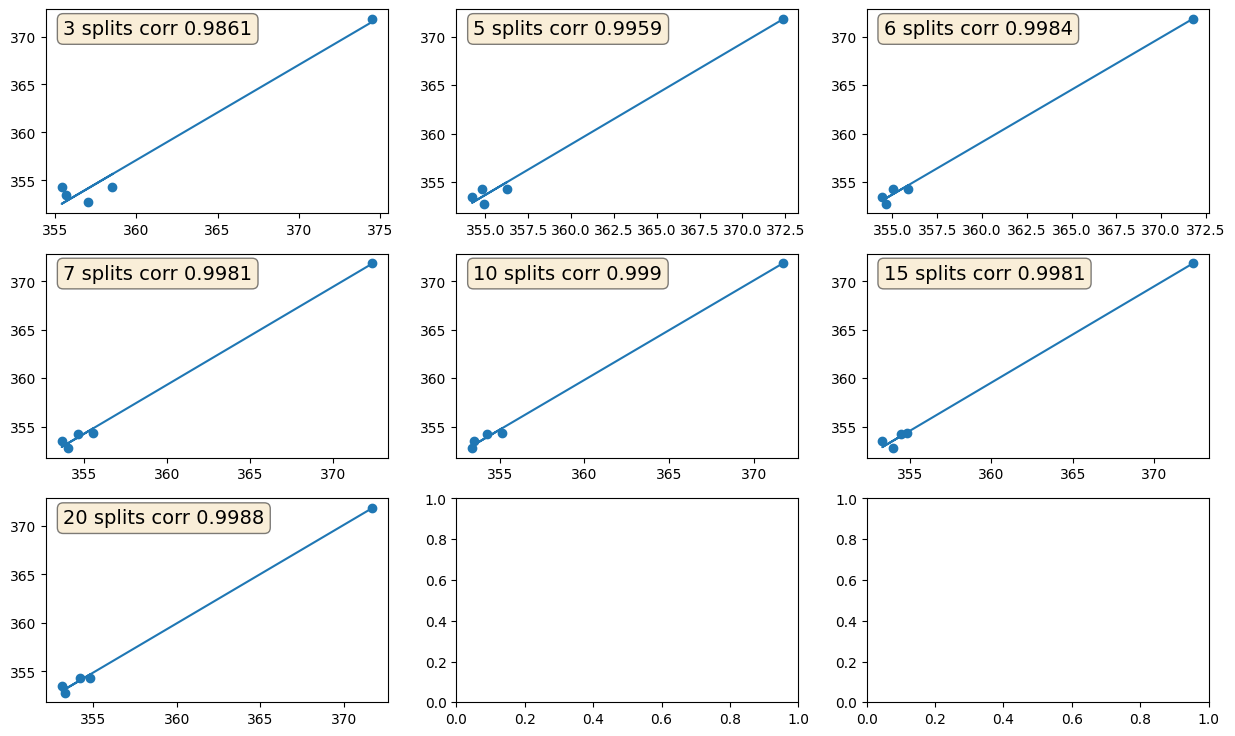

In [13]:
ideal_scores = ideal_scores_log['valid_error'].dropna()
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
k = [3, 5, 6, 7, 10, 15, 20]
fig, axes = plt.subplots(3, 3, figsize=(15, 3*3))
axes = axes.flatten()
for i, n_splits in enumerate(k):
    cv_means = models_log[models_log['no_of_fold'] == n_splits]['valid_error']
    
    corr, _ = pearsonr(ideal_scores.values, cv_means.values)
    coef, bias = np.polyfit(cv_means.to_list(), ideal_scores.to_list(), 1)
    line = coef * np.asarray(cv_means) + bias
    axes[i].scatter(cv_means, ideal_scores)
    axes[i].plot(cv_means, line)
    axes[i].text(0.05, 0.95, f'{n_splits} splits corr {round(corr, 4)}', transform=axes[i].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


You can see from the plots that we got the best correlation with ideal value if the k value is set 10. Although the differences are not that great which probably due to 3 repeation and large dataset size when getting model scores for each fold
****So we can see that k value of 10 is the best for evaluation the 5 models we used(normally we should have used more alogrithms). k value of 6 is a good choice. Although 20 is good but it would take too much time compared to 6****

# EVALUATE MODELS

I know it may seems that we have already found best way to evaluate models but it is obously not the case. there is a problem

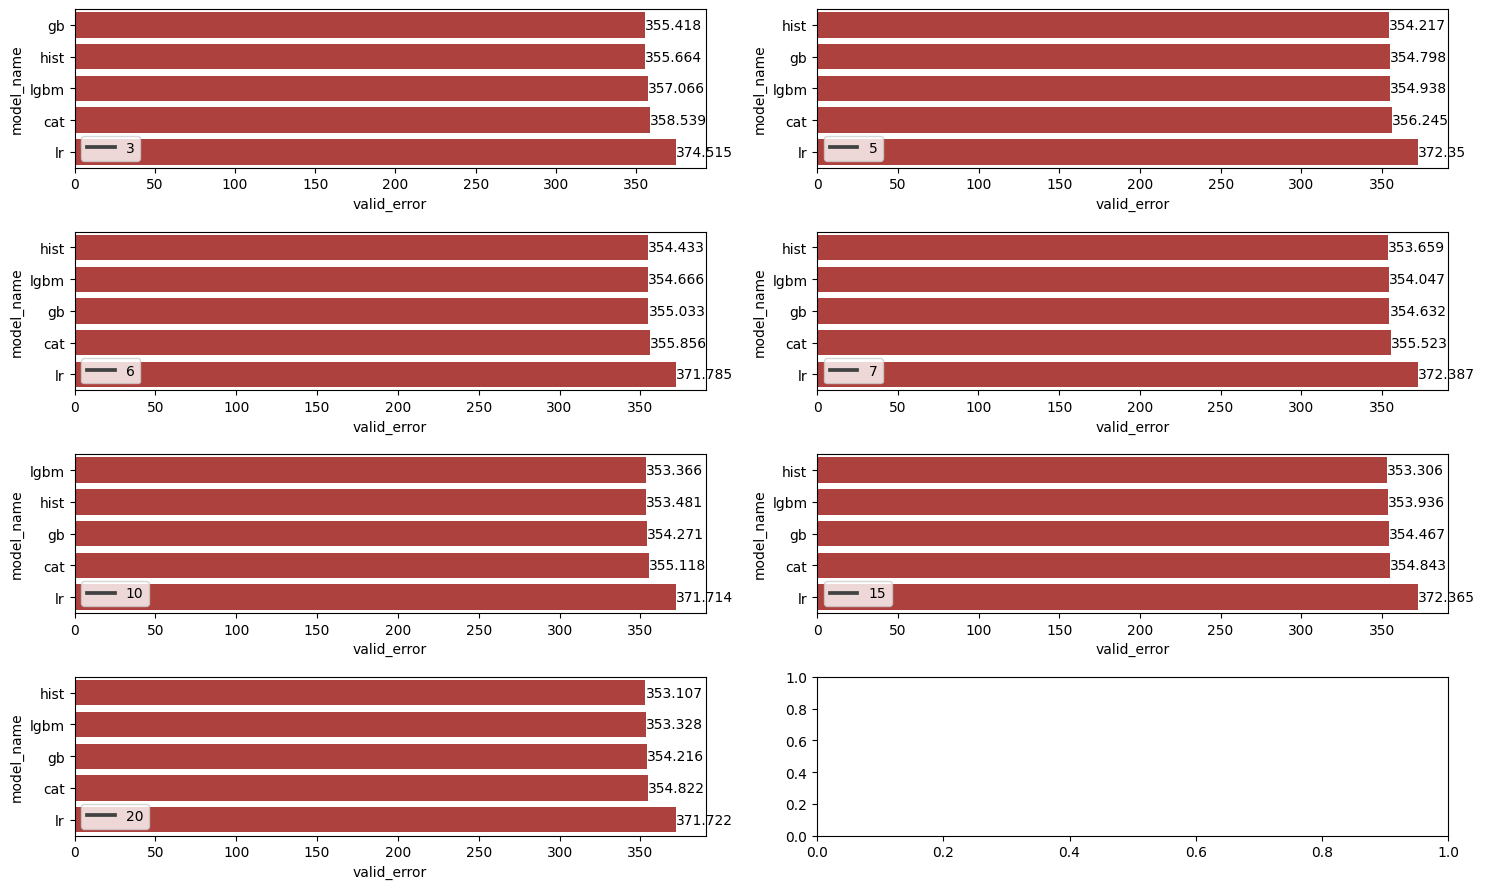

In [14]:
fig, ax = plt.subplots(4, 2, figsize=(15, 3*3))
axes = ax.flatten()
for i, n_splits in enumerate(k):
    data = models_log[models_log['no_of_fold'] == n_splits].sort_values(by='valid_error')
    sns.barplot(data=data, x='valid_error', y='model_name', ax=axes[i], color='#C0302B')
    axes[i].bar_label(axes[i].containers[0])
    axes[i].legend([n_splits], loc='lower left')

plt.tight_layout()

As you can see althouh hist gradient boosting is performing the best most of the time it is not fixed. The model is alternating between the hist, gb and lgbm. So even finding the best k and evaluating model is good it may not work all the time. So we need to find models which are good regardless of the value of k. 

<B>If we are done with buliding final models and just want to choose an single model to submit than taking various values for k then evaluating model is a good choice to reduce randomness</b>

In [19]:
def evaluate_model_splits(model_name, model_pipeline, y_pipeline, _X, _y, split_sr, features, n_splits_list=[3, 5, 10], random_state=42, verbose=True):
    len_y = len(_y)
    len_splits = len(n_splits_list)

    oof_preds = np.zeros(len_y * len_splits).reshape(len_splits, len_y)
    models_pipeline = []
    scores_train = []
    scores_val = []
    train_means = []
    val_means = []

    
    for index, n_splits in enumerate(n_splits_list):
        if verbose:
            print("#"*25)
            print("#"*15, f"traininng model {model_name} with fold {n_splits}")
            print("#"*25)
            
        splitter = Splitter(n_splits=n_splits) 
        splits = 0
        for X_train, X_val, y_train, y_val, train_idx, val_idx in splitter.split_data(_X, _y, split_sr, random_state):
#         transforming y for distance based algorithm
            pros_y_train = y_pipeline.fit_transform(y_train.to_frame()).flatten()
#         fitting model
            model_pipeline.fit(X_train, pros_y_train)
#         making predictions for train and validation set
            train_preds = y_pipeline.inverse_transform(model_pipeline.predict(X_train).reshape(-1, 1)).flatten()
            val_preds = y_pipeline.inverse_transform(model_pipeline.predict(X_val).reshape(-1, 1)).flatten()
#         storing validation preds for future use
            oof_preds[index, val_idx] = val_preds
#         train and validation score in each split     
            score_train = mean_absolute_error(y_train, train_preds)
            score_val = mean_absolute_error(y_val, val_preds)
            
            models_pipeline.append(deepcopy(model_pipeline))
            scores_train.append(score_train)
            scores_val.append(score_val)
            train_means.append(y_train.mean())
            val_means.append(val_preds.mean())

            splits += 1
            if verbose:
                print(f"fold {splits} mean absoulte error {score_val}")

          
    oof_preds_mean = oof_preds
    mean_train_score = np.mean(scores_train)
    mean_val_score = np.mean(scores_val)
    cv_gap = mean_train_score - mean_val_score
    val_std = np.std(scores_val)
    sem = np.abs(np.array(train_means) - np.array(val_means)).mean()
    print()
    print(f'{model_name} Average  mean abosulte error: {np.mean(scores_val)}')

# returns all the trained models for each splits and also the predictions in each repeat, mean train score and validation score
# also the difference between train and validation score, the standard devidations in validation and standard error around the mean
# in each repeats
    return models_pipeline, oof_preds_mean, mean_train_score, mean_val_score, cv_gap, val_std, sem

In [20]:
%%time
n_splits_list=[3, 5, 6, 10]
random_state=42
classifiers = {
    "lr": LinearRegression(),
    'svr': SVR(),
    "gb": GradientBoostingRegressor(random_state=0),
    'hist': HistGradientBoostingRegressor(random_state=0),
    'lgbm': LGBMRegressor(random_state=0),
    "cat": CatBoostRegressor(silent=True, random_state=0)
}

models_log2 = pd.DataFrame(columns=['model_name', 'train_error', "valid_error", "cv_gap", "std", "sem"],
                          index=range(len(classifiers)))
index = 0

process_y = make_pipeline(StandardScaler())

for model_name, model in classifiers.items():


    model_pipe = make_pipeline(StandardScaler(), model)  
    _models, _oof_preds, _train_score, _oof_val_score, _cv_gap, _std, _sem = evaluate_model_splits(model_name, model_pipe, process_y, 
                                                                        X, y, split_sr,  feats,
                                                                        n_splits_list=n_splits_list, random_state=random_state)



    models_log2.loc[index] = [model_name, _train_score, _oof_val_score, _cv_gap, _std, _sem]
    index += 1

#########################
############### traininng model lr with fold 3
#########################
fold 1 mean absoulte error 410.6996078419646
fold 2 mean absoulte error 369.23809557628925
fold 3 mean absoulte error 370.0744948160963
#########################
############### traininng model lr with fold 5
#########################
fold 1 mean absoulte error 378.65103565544047
fold 2 mean absoulte error 367.6504726776342
fold 3 mean absoulte error 374.0247568336743
fold 4 mean absoulte error 369.09447629688964
fold 5 mean absoulte error 369.8875426053809
#########################
############### traininng model lr with fold 6
#########################
fold 1 mean absoulte error 373.4616063297501
fold 2 mean absoulte error 378.1259995807713
fold 3 mean absoulte error 369.77306462837726
fold 4 mean absoulte error 368.63029733892336
fold 5 mean absoulte error 377.0611270843878
fold 6 mean absoulte error 363.7556415404145
#########################
############### traininng model lr with fo

In [21]:
models_log2

,model_name,train_error,valid_error,cv_gap,std,sem
0,lr,370.901931,373.271915,-2.369984,9.364359,10.799099
1,svr,344.030948,358.906633,-14.875685,5.92618,15.299915
2,gb,343.427051,354.611132,-11.184081,6.510305,8.632139
3,hist,328.16248,354.97187,-26.80939,7.155158,9.694101
4,lgbm,318.656539,354.792229,-36.13569,7.075082,8.680968
5,cat,303.975812,356.306313,-52.330501,6.31046,8.401827


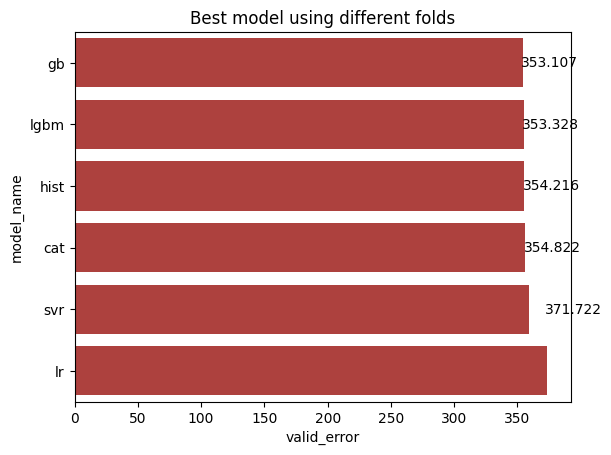

In [24]:
data = models_log2.sort_values(by='valid_error')
ax = sns.barplot(data=data, x='valid_error', y='model_name', color='#C0302B')
ax.bar_label(axes[i].containers[0])
plt.title("Best model using different folds");

<b><p style='color:#C0302B'>In sort-:<b>
<ul style='color: #C0302B'>
    <li>If we want to just get an overview of how an model performs for a dataset and later we would do feature engineeing, transformation to improve our score than just finding the best value for k in the method mentioned is enough or just going the popular k value 10 or 5 is enough(with repeated cv) as we just to want to know if new features are improving our score or not. Moreover we have public leaderboard score for more verification kaggle notebook.</li>
    <li>But suppose we are done with buliding final models and just want to choose an single model to submit than taking various values for k then evaluating model is a good choice to reduce randomness.</li>
</ul>  
</p>
    
****This is just my personal opinion if someone has any opinion or argument about this notebook than write in the comments. All opinions are highly welcomed****